In [1]:
import keras
import os
os.environ['KERAS_BACKEND']='tensorflow'
import h5py
import cv2
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1337)  # for reproducibility

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.callbacks import TensorBoard

def setGPU():   
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.5
    set_session(tf.Session(config=config))
#setGPU()

print('libs loaded')

/home/ian/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


libs loaded


In [2]:
# perameters

size = 256

(341, 256, 256, 1)
(341, 256, 256, 1)


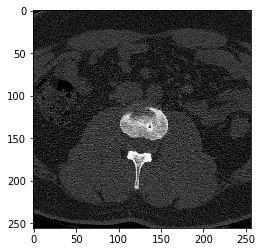

In [3]:
def load_data():
    filenames = []
    for root, dirs, files in os.walk('./data/x'):
        for name in files:
            filenames.append(os.path.join(root, name).split('/')[-1])

    num = len(filenames)
    size = 256
    data_shape = (num, size, size)
    X = np.zeros(data_shape)
    Y = np.zeros(data_shape)
    
    for i in range(num):
        f = filenames[i]
        img = np.array(cv2.imread('./data/x/' + f, 0))
        img2 = np.array(cv2.imread('./data/y/' + f, 0))
        X[i, :, :] = img
        Y[i, :, :] = img2
    
    X = X.reshape(num, size, size, 1)
    Y = Y.reshape(num, size, size, 1)
    
    X = X.astype('float32')
    Y = Y.astype('float32')
    
    X /= 255
    Y /= 255
    
    print(X.shape)
    
    return X, Y

X_train, Y_train = load_data()
print(X_train.shape)
plt.imshow(X_train[0,:,:,0], cmap='gray')



In [8]:
import random
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

def batch():
    size = 256
    num_of_output = 10
    num_of_img = X_train.shape[0]
    
    random_list = random.sample(range(num_of_img), num_of_output)
    #print(random_list)
    
    data_shape = (num_of_output, size, size, 1)
    X = np.zeros(data_shape)
    Y = np.zeros(data_shape)
    
    for i in range(num_of_output):
        X[i] = X_train[random_list[i]]
        Y[i] = Y_train[random_list[i]]
        
    X = seq.augment_images(X)
        
    return X, Y
#batch(X_train, Y_train)
    

In [5]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

model = unet()

/home/ian/.local/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ian/.local/lib/python3.5/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ian/.local/lib/python3.5/site-packages/ipykernel_launcher.py:27: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ian/.local/lib/python3.5/site-packages/ipykernel_launcher.py:32: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ian/.local/lib/python3.5/site-packages/ipykernel_launc

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

/home/ian/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [9]:

# training
nb_epoch = 10
for e in range(nb_epoch):
    print("epoch %d" % e)
    X_batch, Y_batch = batch()
    model.fit(X_batch, Y_batch)

epoch 0
Epoch 1/1
10/10 [==============================] - 12s 1s/step - loss: 0.7050 - acc: 0.0754
epoch 1
Epoch 1/1
10/10 [==============================] - 1s 57ms/step - loss: 0.6839 - acc: 0.8512
epoch 2
Epoch 1/1
10/10 [==============================] - 1s 70ms/step - loss: 0.6628 - acc: 0.9045
epoch 3
Epoch 1/1
10/10 [==============================] - 1s 67ms/step - loss: 0.5932 - acc: 0.9117
epoch 4
Epoch 1/1
10/10 [==============================] - 1s 68ms/step - loss: 0.4689 - acc: 0.9044
epoch 5
Epoch 1/1
10/10 [==============================] - 1s 70ms/step - loss: 0.6448 - acc: 0.9015
epoch 6
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.4068 - acc: 0.9172
epoch 7
Epoch 1/1
10/10 [==============================] - 0s 46ms/step - loss: 0.4490 - acc: 0.9113
epoch 8
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.4730 - acc: 0.9049
epoch 9
Epoch 1/1
10/10 [==============================] - 0s 45ms/step - loss: 0.4889 - acc

In [9]:
# save
model.save('./save/model_unet.h5')   # HDF5 file, you have to pip3 install h5py if don't have it
del model  # deletes the existing model

In [10]:
# load
model = load_model('./save/model_unet.h5')

(1, 256, 256, 1)


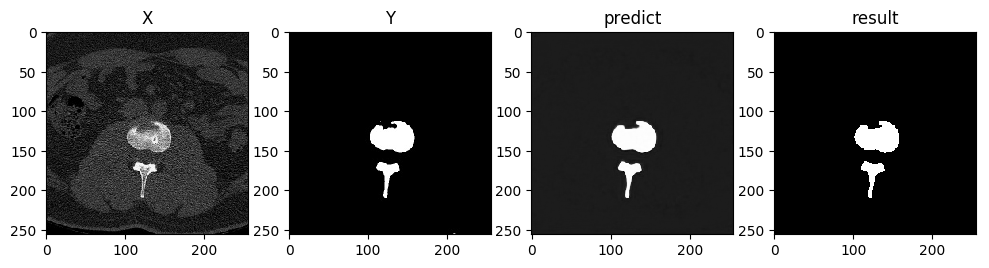

(1, 256, 256, 1)


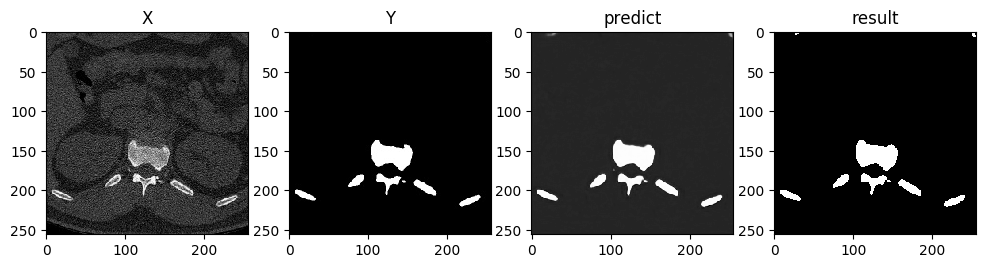

(1, 256, 256, 1)


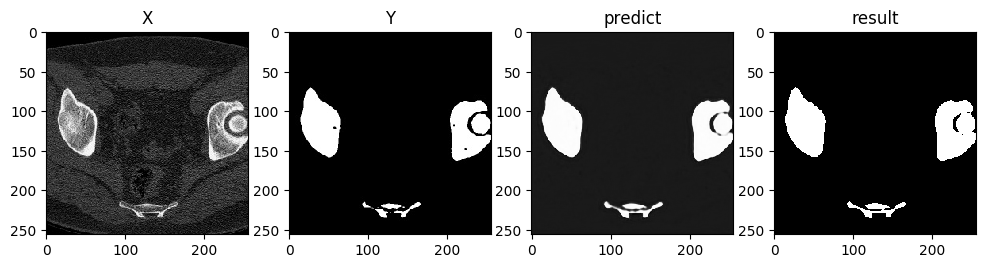

(1, 256, 256, 1)


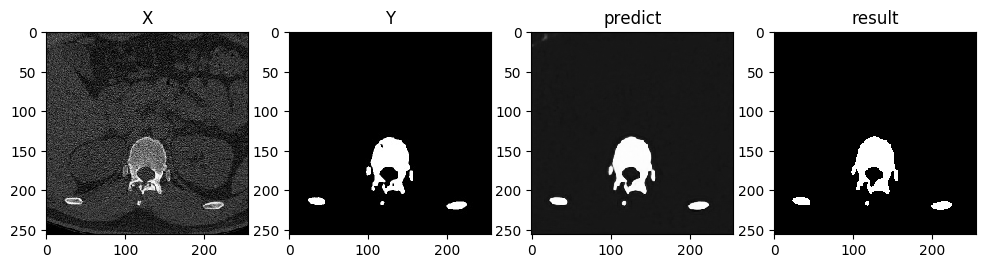

(1, 256, 256, 1)


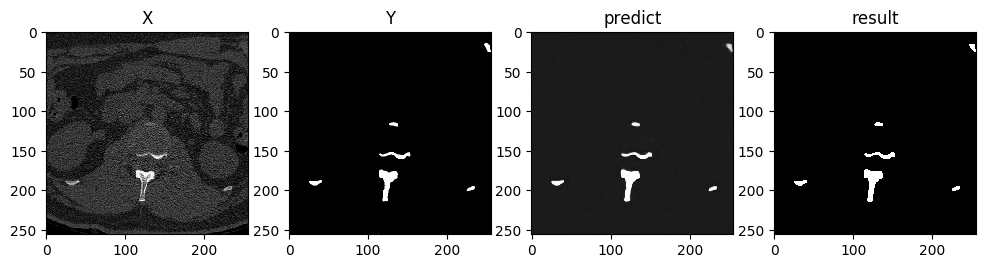

(1, 256, 256, 1)


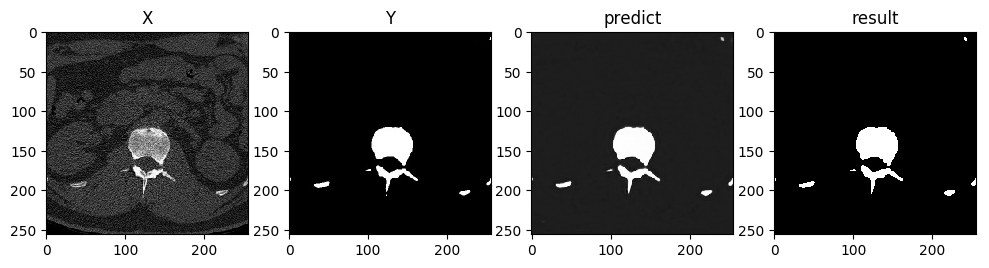

(1, 256, 256, 1)


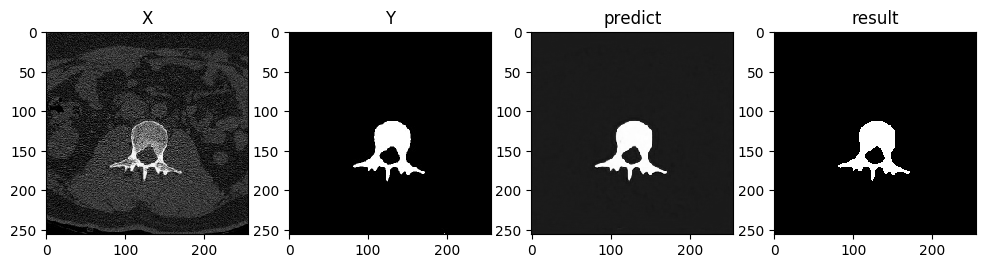

(1, 256, 256, 1)


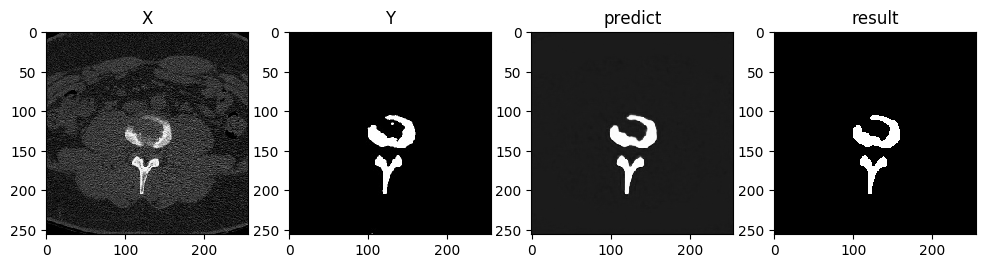

(1, 256, 256, 1)


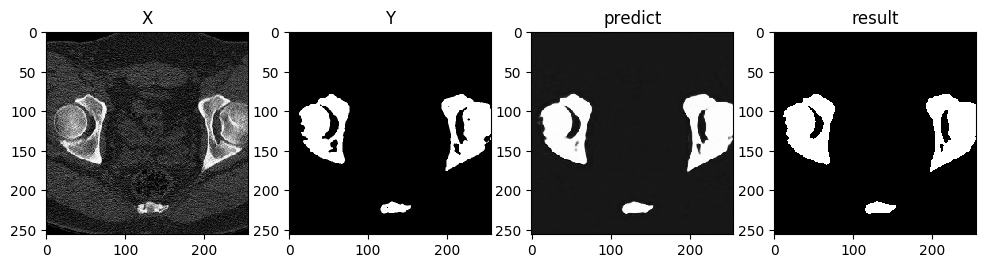

(1, 256, 256, 1)


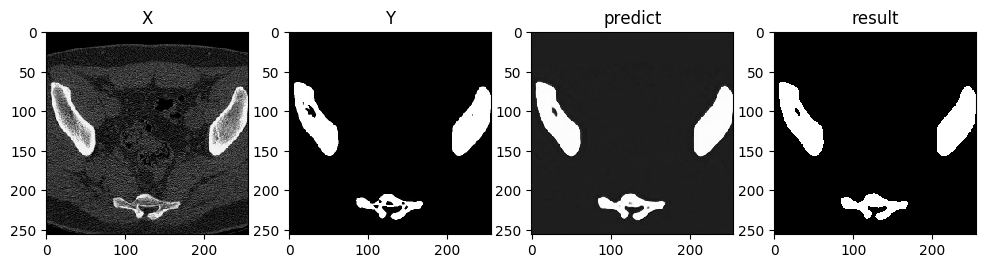

(1, 256, 256, 1)


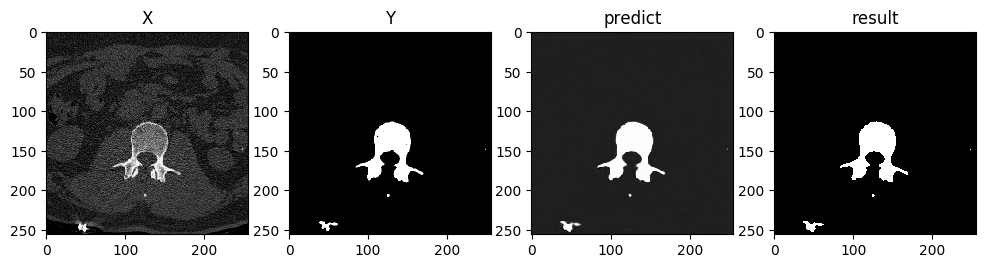

(1, 256, 256, 1)


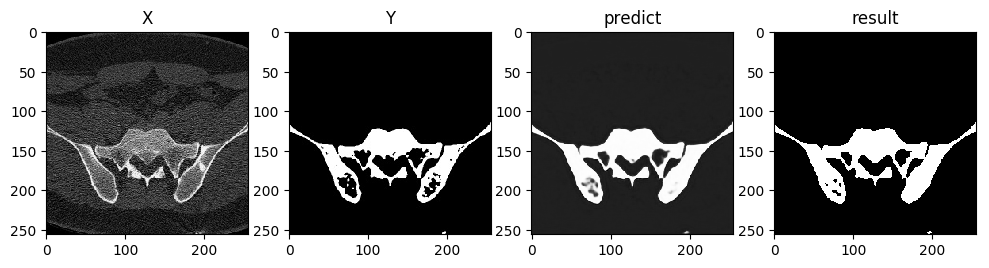

(1, 256, 256, 1)


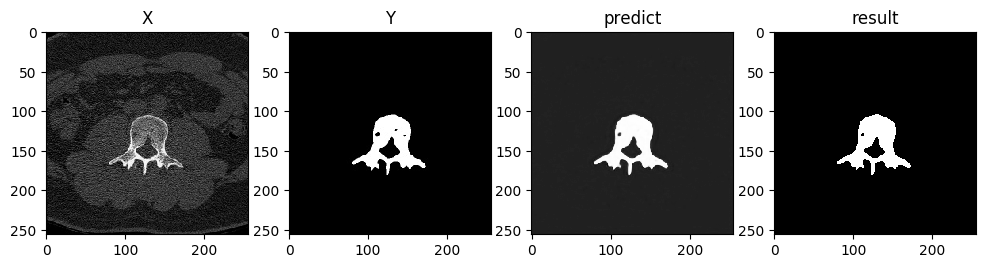

(1, 256, 256, 1)


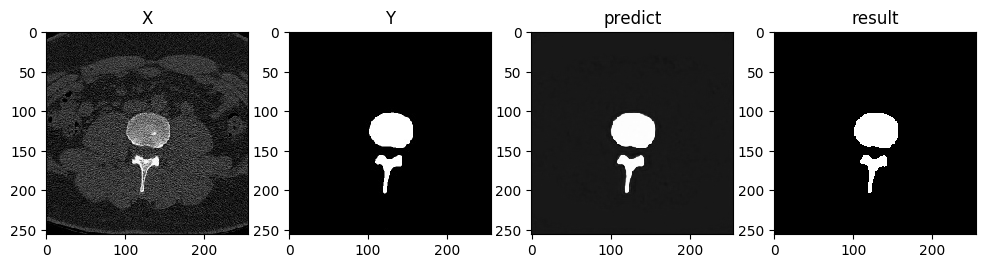

(1, 256, 256, 1)


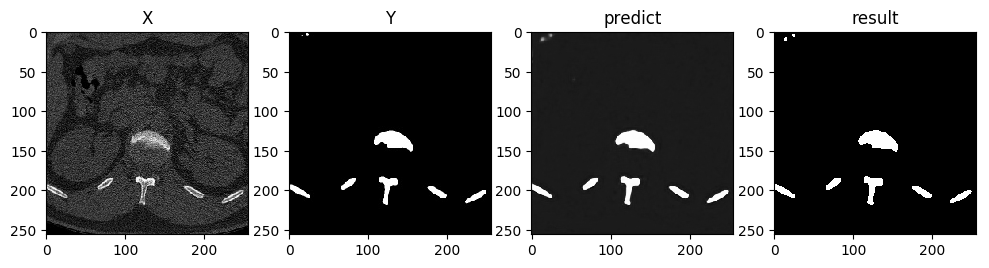

(1, 256, 256, 1)


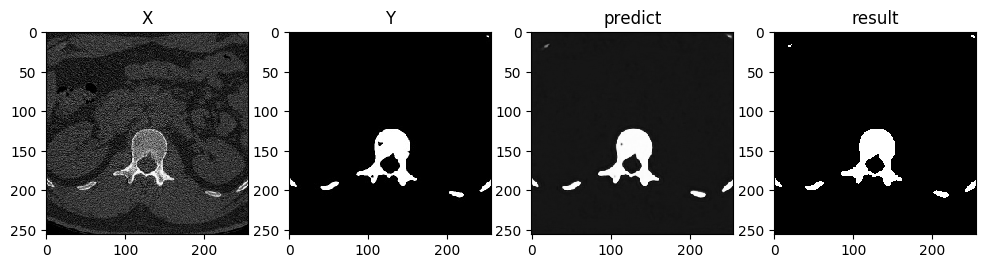

(1, 256, 256, 1)


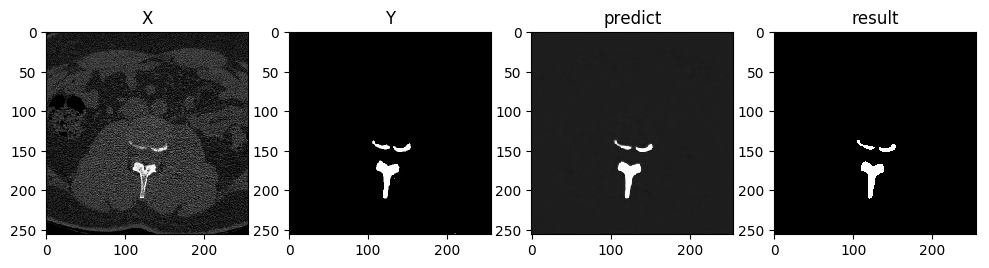

(1, 256, 256, 1)


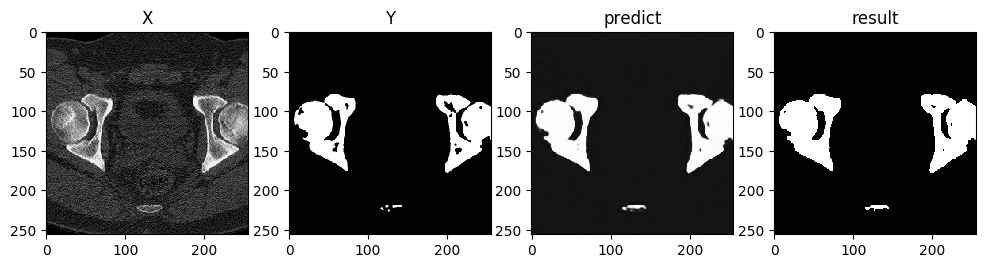

(1, 256, 256, 1)


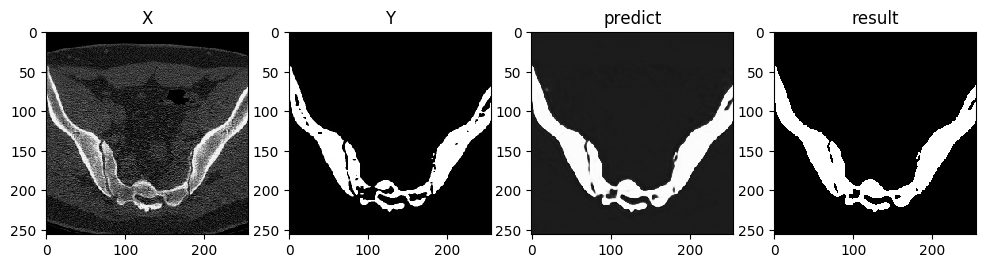

(1, 256, 256, 1)


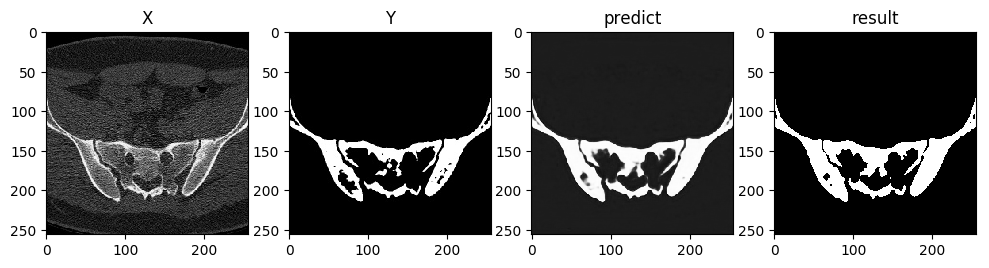

(1, 256, 256, 1)


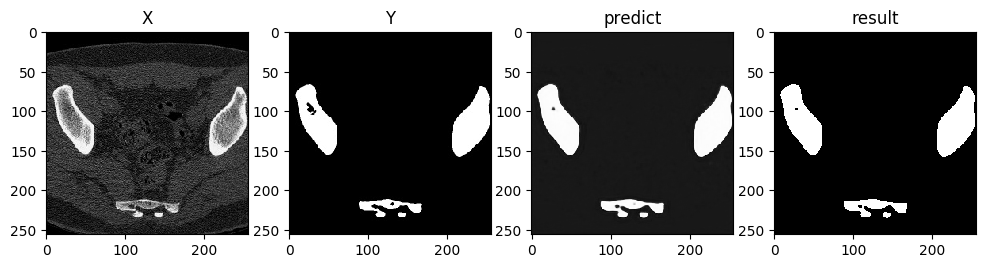

(1, 256, 256, 1)


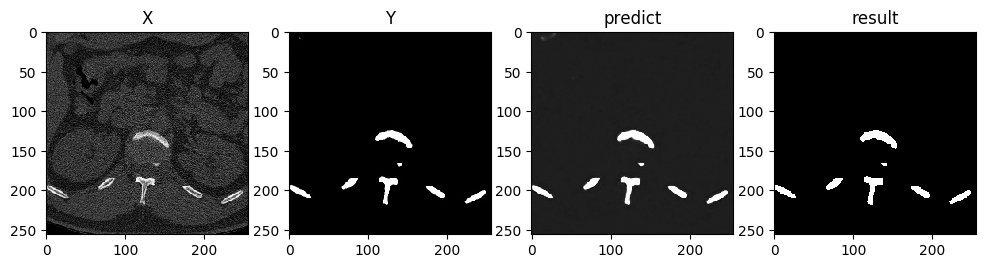

(1, 256, 256, 1)


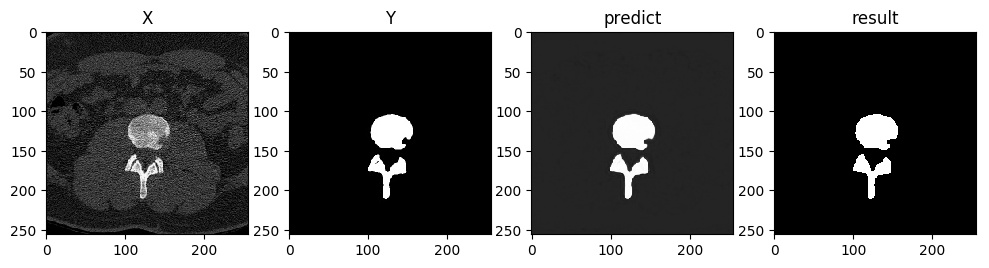

(1, 256, 256, 1)


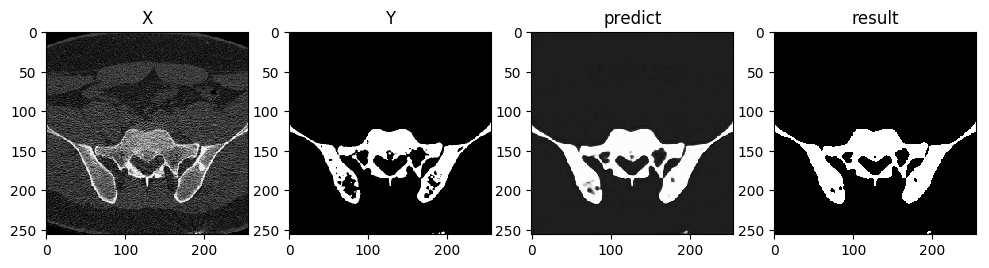

(1, 256, 256, 1)


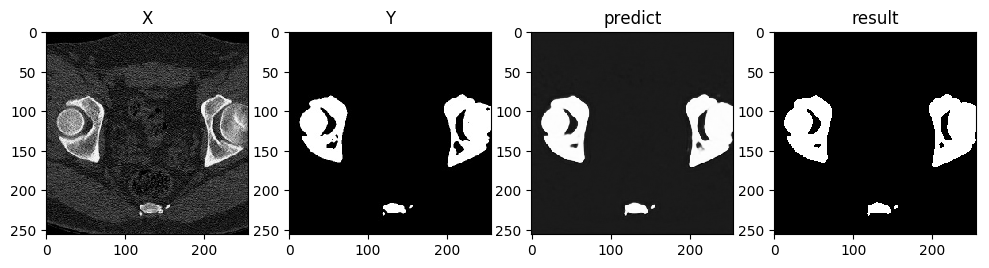

(1, 256, 256, 1)


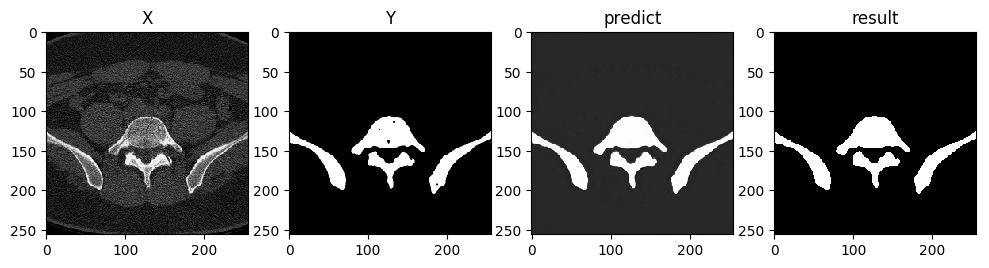

(1, 256, 256, 1)


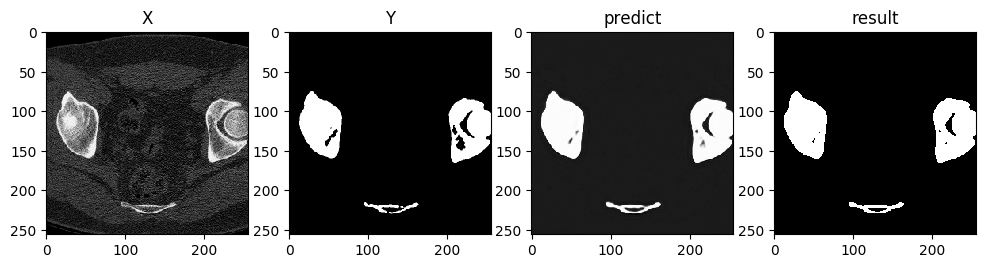

(1, 256, 256, 1)


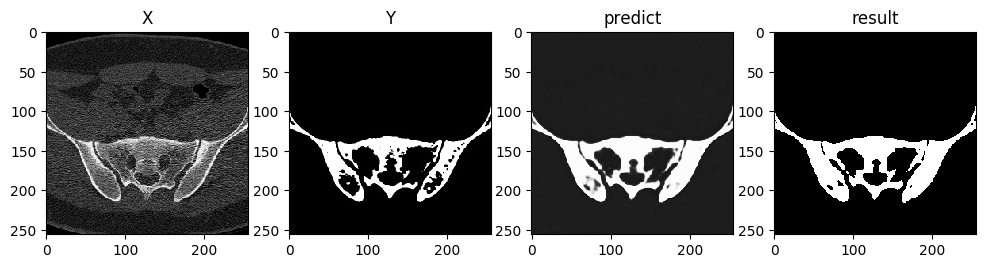

(1, 256, 256, 1)


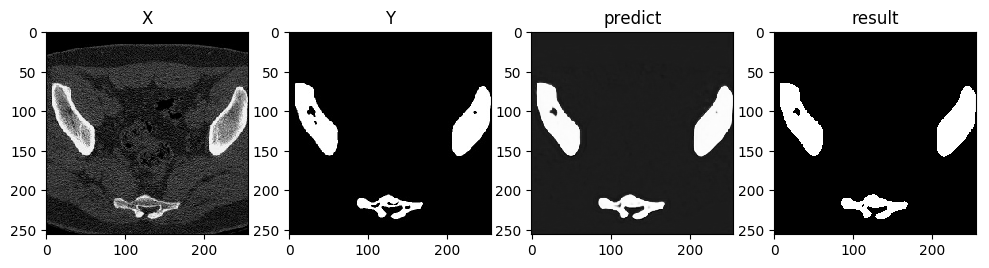

(1, 256, 256, 1)


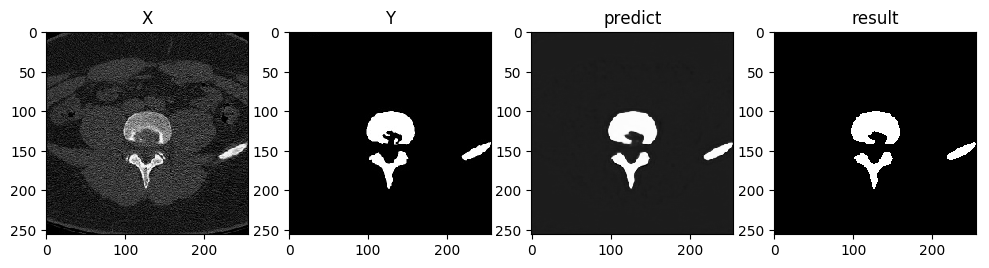

(1, 256, 256, 1)


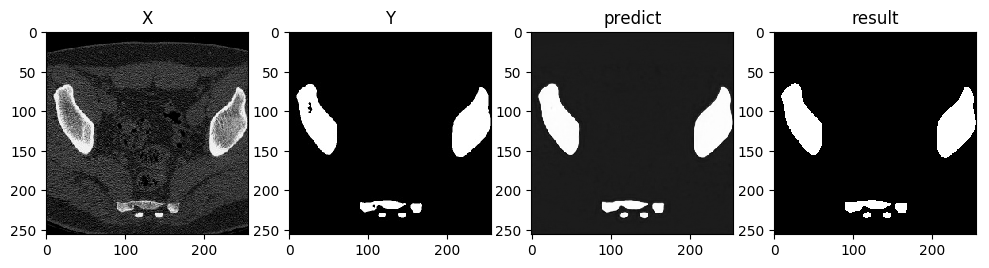

In [11]:
#num = 3
for num in range(0, 31):

    X = X_train[num:num+1]
    Y = Y_train[num:num+1]

    img = model.predict(X)
    img2 = img > 0.5
    print(img.shape)


    plt.figure(num=None, figsize=(12, 15), dpi=100, facecolor='w', edgecolor='k')

    plt.subplot(141), plt.title('X'), plt.imshow(X.reshape(size,size), cmap='gray')

    plt.subplot(142), plt.title('Y'), plt.imshow(Y.reshape(size,size), cmap='gray')

    plt.subplot(143), plt.title('predict'), plt.imshow(img.reshape(size,size), cmap='gray')

    plt.subplot(144), plt.title('result'), plt.imshow(img2.reshape(size,size), cmap='gray')

    plt.show()